In [1]:
import glob
import os

import SimpleITK as sitk
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
brats_folder = './data'
config = {}
config["modalities"] = ["T1", "T1c", "Flair", "T2"]
config['truth'] = ['truth']
config["data_dir"] = os.path.abspath("./data")

In [3]:
# def get_image(subject_folder, name):
#     return glob.glob(os.path.join(subject_folder, "*" + name + ".*", "*" + name + ".*.mha"))[0]

def get_image(subject_folder, name):
    return glob.glob(os.path.join(subject_folder, name + ".nii.gz"))[0]

In [4]:
for subject_folder in glob.glob(os.path.join(brats_folder, '*', '*'))[:10]:
    if os.path.isdir(subject_folder):
        subject = os.path.basename(subject_folder)
        print(subject)
        print(os.path.join(config['data_dir'], os.path.basename(os.path.dirname(subject_folder)),
                                              subject))
        
subject_folder = glob.glob(os.path.join(brats_folder, '*', '*'))[:10]

brats_2013_pat0001_1
/Users/namco/Projects/3DUnetCNN/src/data/HGG/brats_2013_pat0001_1
brats_2013_pat0002_1
/Users/namco/Projects/3DUnetCNN/src/data/HGG/brats_2013_pat0002_1
brats_2013_pat0003_1
/Users/namco/Projects/3DUnetCNN/src/data/HGG/brats_2013_pat0003_1
brats_2013_pat0004_1
/Users/namco/Projects/3DUnetCNN/src/data/HGG/brats_2013_pat0004_1
brats_2013_pat0005_1
/Users/namco/Projects/3DUnetCNN/src/data/HGG/brats_2013_pat0005_1
brats_2013_pat0006_1
/Users/namco/Projects/3DUnetCNN/src/data/HGG/brats_2013_pat0006_1
brats_2013_pat0007_1
/Users/namco/Projects/3DUnetCNN/src/data/HGG/brats_2013_pat0007_1
brats_2013_pat0008_1
/Users/namco/Projects/3DUnetCNN/src/data/HGG/brats_2013_pat0008_1
brats_2013_pat0009_1
/Users/namco/Projects/3DUnetCNN/src/data/HGG/brats_2013_pat0009_1
brats_2013_pat0010_1
/Users/namco/Projects/3DUnetCNN/src/data/HGG/brats_2013_pat0010_1


In [6]:
for modality in config['modalities'] + config['truth']:
    print(get_image(subject_folder[0], modality))

./data/HGG/brats_2013_pat0001_1/T1.nii.gz
./data/HGG/brats_2013_pat0001_1/T1c.nii.gz
./data/HGG/brats_2013_pat0001_1/Flair.nii.gz
./data/HGG/brats_2013_pat0001_1/T2.nii.gz
./data/HGG/brats_2013_pat0001_1/truth.nii.gz


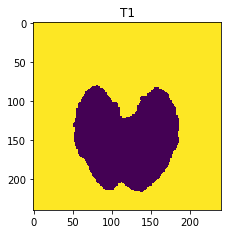

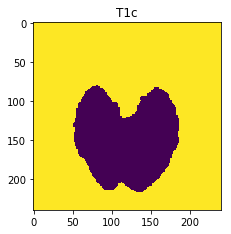

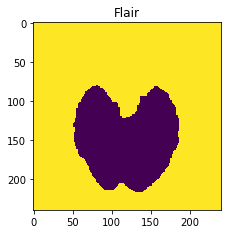

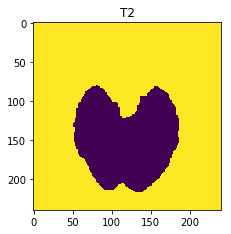

In [31]:
# Get all the images
z = 50
n = 1
background_image = None
for modality in config['modalities']:
# for modality in ['T1', 'T1c']:
    image_name = get_image(subject_folder, modality)
    image = sitk.ReadImage(image_name)
    if background_image:
        background_image = sitk.And(image == 0, background_image)
    else:
        background_image = image == 0
    plt.figure(figsize=(20,20))
    plt.subplot(5, 1, n)
    background_slice = sitk.GetArrayViewFromImage(background_image)[z,:,:]
    plt.imshow(background_slice)
#     slice_ = sitk.GetArrayViewFromImage(image)[z,:,:]
#     background_slice = sitk.GetArrayViewFromImage(image==0)[z,:,:]

#     plt.imshow(background_slice)
    plt.title(modality)
    n += 1


In [7]:
for item in subject_folder:
    image = sitk.ReadImage(get_image(item, 'T1'))
    print(image.GetSpacing())
# slice = sitk.GetArrayViewFromImage(image)[z,:,:]
# slice[100]
# plt.imshow(slice)

(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)


In [12]:
image = sitk.ReadImage(get_image(subject_folder, '.MR_T2'))
maskImage = sitk.OtsuThreshold(image, 0, 1, 200)
image = sitk.Cast( image, sitk.sitkFloat32 )
image = sitk.Shrink( image, [ 2 ] * image.GetDimension() )
maskImage = sitk.Shrink( maskImage, [ 2 ] * image.GetDimension() )

In [46]:
image.GetSize()
# slice = sitk.GetArrayViewFromImage(image)[100,:,:]
# plt.imshow(slice)
# slice[100]

(240, 240, 155)

In [57]:
# slice = sitk.GetArrayViewFromImage(image)[100,:,:]
image.GetSize()

(240, 240, 155)

In [14]:
corrector = sitk.N4BiasFieldCorrectionImageFilter()
output = corrector.Execute( image, maskImage ) 

In [36]:
slice = sitk.GetArrayViewFromImage(output)[40,:,:]
plt.imshow(slice)
slice[40]

NameError: name 'output' is not defined

In [ ]:
image_array = sitk.GetArrayFromImage(image)
normalized = (image_array - image_array.mean())/image_array.std()
normalized_image = sitk.GetImageFromArray(normalized)
normalized_image.GetSize()

In [ ]:
slice = sitk.GetArrayViewFromImage(normalized_image)[z,:,:]
plt.imshow(slice)
slice[100]

In [ ]:
# slice = sitk.GetArrayViewFromImage(normalized_image)[z,:,:]
# plt.imshow(slice)
rescaled = sitk.RescaleIntensity(normalized_image, 0, 1)
slice = sitk.GetArrayViewFromImage(rescaled)[z,:,:]
plt.imshow(slice)
# slice[100]

In [ ]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing